<a href="https://colab.research.google.com/github/desyningrum31/Deeplearning/blob/main/M6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download -d desypuspitaningrum/klasifikasi-merek-handphone
!mkdir klasifikasi-merek-handphone

 76% 2.00M/2.65M [00:01<00:00, 2.23MB/s]
100% 2.65M/2.65M [00:01<00:00, 2.44MB/s]


In [3]:
!unzip /content/klasifikasi-merek-handphone.zip -d /content/klasifikasi-merek-handphone

Archive:  /content/klasifikasi-merek-handphone.zip
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/1.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/10.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/100.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/11.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/12.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/13.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/14.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/15.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/16.jpg  
  inflating: /content/klasifikasi-merek-handphone/Klasifikasi Merek Handphone/Iphone/17.jpg  
  inflati

In [4]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [5]:
dataset_path = Path(r'/content/klasifikasi-merek-handphone')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [6]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/klasifikasi-merek-handphone/Klasifika...,Vivo
1,/content/klasifikasi-merek-handphone/Klasifika...,Vivo
2,/content/klasifikasi-merek-handphone/Klasifika...,Vivo
3,/content/klasifikasi-merek-handphone/Klasifika...,Vivo
4,/content/klasifikasi-merek-handphone/Klasifika...,Vivo


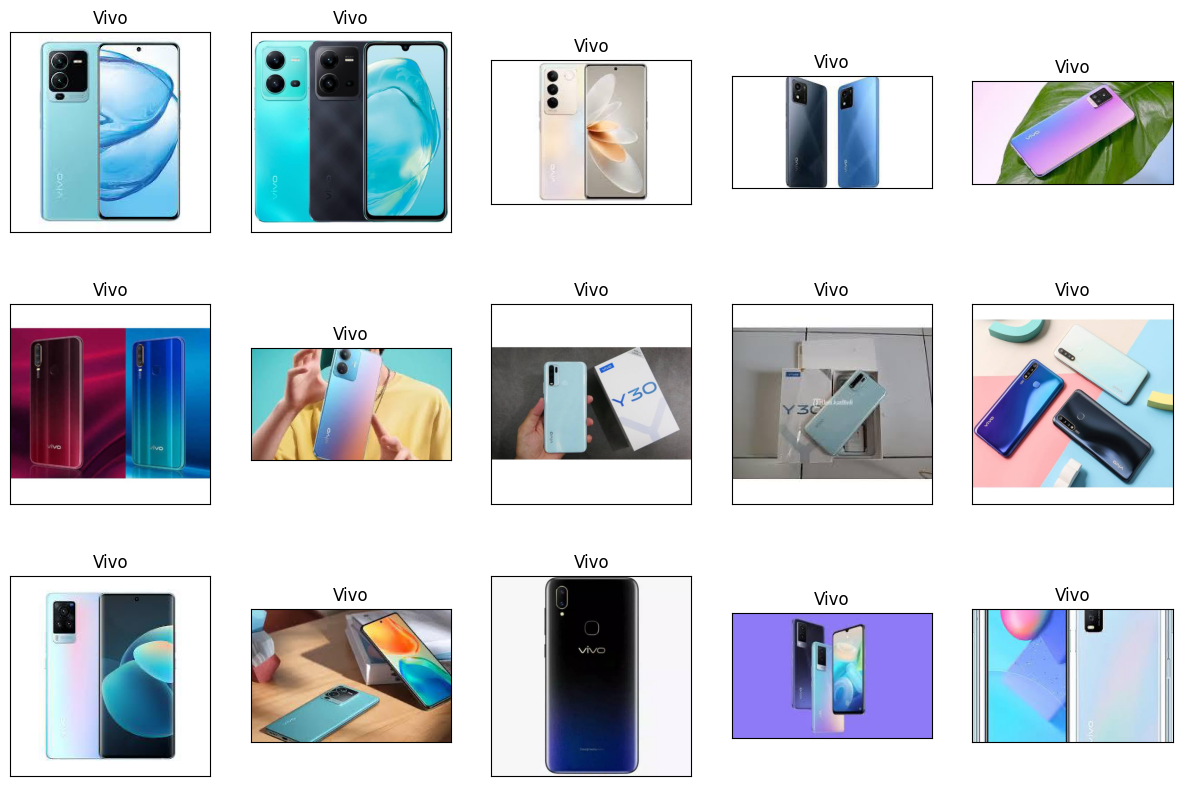

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [8]:
df.label.value_counts()

Vivo       100
Samsung    100
Iphone     100
Name: label, dtype: int64

In [9]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Vivo       100
Samsung    100
Iphone     100
Name: label, dtype: int64

In [10]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [11]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [12]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [13]:
input_shape = (200, 200, 3)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [22]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 10000, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 5s 464ms/step - loss: 0.8627 - accuracy: 0.6131 - val_loss: 1.2937 - val_accuracy: 0.5476
Epoch 2/100
6/6 [==============================] - 2s 470ms/step - loss: 0.8355 - accuracy: 0.6488 - val_loss: 0.9797 - val_accuracy: 0.5714
Epoch 3/100
6/6 [==============================] - 3s 482ms/step - loss: 0.7624 - accuracy: 0.6845 - val_loss: 0.8193 - val_accuracy: 0.6190
Epoch 4/100
6/6 [==============================] - 2s 380ms/step - loss: 0.7454 - accuracy: 0.6964 - val_loss: 0.8419 - val_accuracy: 0.5714
Epoch 5/100
6/6 [==============================] - 2s 371ms/step - loss: 0.7083 - accuracy: 0.7083 - val_loss: 0.8848 - val_accuracy: 0.6190
Epoch 6/100
6/6 [==============================] - 2s 422ms/step - loss: 0.7143 - accuracy: 0.7143 - val_loss: 0.8862 - val_accuracy: 0.6429
Epoch 7/100
6/6 [==============================] - 3s 537ms/step - loss: 0.6585 - accuracy: 0.7560 - val_loss: 0.9679 - val_accuracy: 0.4762
Epoch 8/100
6

In [23]:
model.save('model-1.h5')

In [24]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

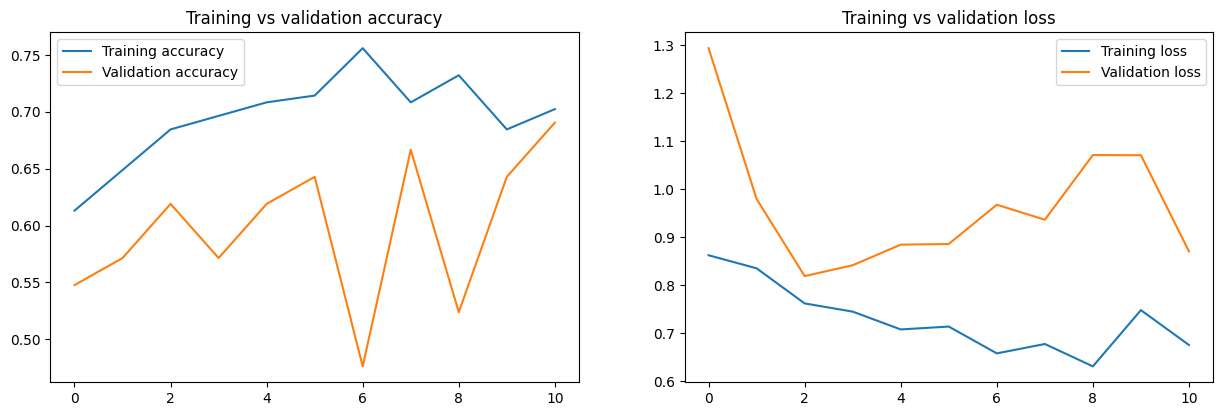

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [26]:
pred = model.predict(test)

3/3 [==============================] - 1s 464ms/step


In [33]:
pred = np.argmax(pred, axis=1)

In [34]:
labels = train.class_indices

In [35]:
labels

{'Iphone': 0, 'Samsung': 1, 'Vivo': 2}

In [36]:
labels = dict((v,k) for k, v in labels.items())

In [37]:
labels

{0: 'Iphone', 1: 'Samsung', 2: 'Vivo'}

In [38]:
y_pred = [labels[k] for k in pred]

In [39]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

      Iphone       0.58      0.58      0.58        24
     Samsung       0.65      0.61      0.62        33
        Vivo       0.60      0.64      0.62        33

    accuracy                           0.61        90
   macro avg       0.61      0.61      0.61        90
weighted avg       0.61      0.61      0.61        90



In [40]:
print(confusion_matrix(x_test.label, y_pred))

[[14  6  4]
 [ 3 20 10]
 [ 7  5 21]]


In [41]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 1s 271ms/step - loss: 1.2251 - accuracy: 0.5778
